## Gender Classification from Face Images Deep Learning

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


### Loading Seeds

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


### Dataset preparation

In [4]:
class FacecomGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label, gender in enumerate(['male', 'female']):
            gender_folder = os.path.join(root_dir, gender)
            for fname in os.listdir(gender_folder):
                self.samples.append((os.path.join(gender_folder, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### Transform and dataloaders 

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = FacecomGenderDataset("data-set/Task_A/train", transform=train_transform)
val_dataset = FacecomGenderDataset("data-set/Task_A/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Model definition

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
model = model.to(device)


c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sibsankar De/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:08<00:00, 5.33MB/s]


### Training setup

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training loop

In [8]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
    return preds, targets


### Training process

In [9]:
best_acc = 0
patience = 3
wait = 0
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    preds, targets = evaluate(model, val_loader)
    acc = np.mean(np.array(preds) == np.array(targets))
    
    print(f"Train Loss: {train_loss:.4f} | Val Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        wait = 0
        torch.save(model.state_dict(), "best_gender_model.pth")
        print("🔥 Best model saved!")
    else:
        wait += 1
        if wait >= patience:
            print("⏸️ Early stopping triggered.")
            break
    scheduler.step()



Epoch 1/20


100%|██████████| 61/61 [02:28<00:00,  2.44s/it]


Train Loss: 0.3726 | Val Accuracy: 0.8341
🔥 Best model saved!

Epoch 2/20


100%|██████████| 61/61 [03:17<00:00,  3.24s/it]


Train Loss: 0.2844 | Val Accuracy: 0.8815
🔥 Best model saved!

Epoch 3/20


100%|██████████| 61/61 [02:51<00:00,  2.81s/it]


Train Loss: 0.2235 | Val Accuracy: 0.9076
🔥 Best model saved!

Epoch 4/20


100%|██████████| 61/61 [03:18<00:00,  3.26s/it]


Train Loss: 0.2101 | Val Accuracy: 0.9028

Epoch 5/20


100%|██████████| 61/61 [03:16<00:00,  3.22s/it]


Train Loss: 0.2029 | Val Accuracy: 0.9076

Epoch 6/20


100%|██████████| 61/61 [03:17<00:00,  3.24s/it]


Train Loss: 0.1969 | Val Accuracy: 0.9147
🔥 Best model saved!

Epoch 7/20


100%|██████████| 61/61 [02:19<00:00,  2.28s/it]


Train Loss: 0.2000 | Val Accuracy: 0.9100

Epoch 8/20


100%|██████████| 61/61 [01:08<00:00,  1.13s/it]


Train Loss: 0.1840 | Val Accuracy: 0.9100

Epoch 9/20


100%|██████████| 61/61 [00:55<00:00,  1.11it/s]


Train Loss: 0.1953 | Val Accuracy: 0.9123
⏸️ Early stopping triggered.


### Evaluation


Classification Report:
              precision    recall  f1-score   support

        male       0.92      0.98      0.95       343
      female       0.86      0.65      0.74        79

    accuracy                           0.91       422
   macro avg       0.89      0.81      0.84       422
weighted avg       0.91      0.91      0.91       422



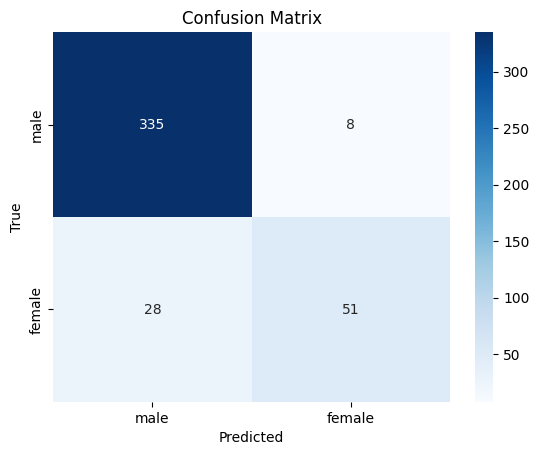

In [10]:
model.load_state_dict(torch.load("best_gender_model.pth"))
preds, targets = evaluate(model, val_loader)

print("\nClassification Report:")
print(classification_report(targets, preds, target_names=["male", "female"]))

cm = confusion_matrix(targets, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["male", "female"], yticklabels=["male", "female"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
